# Adversarial Search: Playing Connect 4


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem:

* Initial state: an empty board.
* Actions: unfilled columns, {0-6} at game start.
* Transition model: When a player drops a piece, it falls straight down to the lowest available space in the column.
* Goal state: Four of the player's pieces are lined up vertically, horizontally, or diagonally.

Each of the 42 squares can have three values (empty, x, or o). However,
* pieces cannot float above empty squares
* the # of x's is always within one of the # of o's
* both players can't have 4-in-a-row at once, etc.

So, the search space has significantly less than this number of states:

In [ ]:
print(3**42)
print('{:.1e}'.format(3**42))

## Task 2: Game Environment and Random Agent [2 point]

Implement an agent that plays randomly and let two random agents play against each other 1000 times. How often does each player win? Is the result expected?

In [47]:
"""sources"""
# winning_move() and its kernels -> https://stackoverflow.com/a/63991845
# in get_actions_ordered(): removing array elements from another array -> https://stackoverflow.com/a/66695755
# show_board() is modified code that M. Hahsler found here -> https://stackoverflow.com/questions/43971138/python-plotting-colored-grid-based-on-values

"""imports"""
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.signal import convolve2d

"""rng seeding"""
np.random.seed(0)

"""constants"""
DEBUG = 0
HEIGHT = 6
WIDTH = 7

"""kernels for winning_move()"""
horizontal_kernel = np.array([[ 1, 1, 1, 1]])
vertical_kernel = np.transpose(horizontal_kernel)
diag1_kernel = np.eye(4, dtype=np.uint8)
diag2_kernel = np.fliplr(diag1_kernel)
detection_kernels = [horizontal_kernel, vertical_kernel, diag1_kernel, diag2_kernel]

def show_board(board, fontsize = 10):  
    """display a board (numpy array)"""
    board = np.copy(board) # make a deep copy first so the original maze is not changed
    board = board + np.ones((HEIGHT, WIDTH), np.int8)
    
    fig, ax = plt.subplots()
    cmap = colors.ListedColormap(['yellow', 'white', 'red'])
    ax.imshow(board, cmap = cmap, norm = colors.BoundaryNorm(list(range(cmap.N + 1)), cmap.N))
    plt.show()

def empty_board(shape=(HEIGHT, WIDTH)):
    return np.zeros(shape, np.int8)

def winning_move(board, player):
    if(player>0):
        for kernel in detection_kernels:
            if (convolve2d(board>0,kernel,mode="valid")==4).any():
                return 1
    elif(player<0):
        for kernel in detection_kernels:
            if (convolve2d(board<0,kernel,mode="valid")==4).any():
                return 1
    return 0

def check_win(board):
    """check the board and return one of 1, -1, d (draw), or n (for next move)"""
    
    # check for win
    if(winning_move(board, 1)): return 'r'
    if(winning_move(board, -1)): return 'y'
    
    # check for draw
    if(np.sum(board == 0) < 1): return 'd'
    
    return 'n'

def get_actions(board):
    """Returns non-full columns as a vector of indices"""
    top_row = board[0][0:WIDTH]
    if(DEBUG): print(top_row)
    actions = np.where(top_row == 0)[0]
    if(DEBUG): print(actions)
    return actions

def other(player): 
    if player > 0: return -1
    else: return 1

def result(state, player, action):
    """Add move to the board"""
    state = state.copy()
    for i in range(HEIGHT):
        if(state[HEIGHT-i-1][action] == 0):
            state[HEIGHT-i-1][action] = player
            return state
    sys.exit('error -> column full')

def utility(state, player = 1):
    """check if a state is terminal and return the utility if it is. None means not a terminal mode."""
    goal = check_win(state)        
    if goal == player: return +1 
    if goal == 'd': return 0  
    if goal == other(player): return -1  # loss is failure
    return None # continue

def is_terminal(state): 
    """check is a state is a terminal state"""
    return check_win(state) != "n"

def random_player(board, player = None):
    """Simple player that chooses a random unfilled column.
       The function argument named 'player' is unused."""
    action = np.random.choice(get_actions(board), size=None, replace=False)
    if(DEBUG): print(action)
    return action

def switch_player(player, r, y):
    if player > 0:
        return -1, y
    else:
        return 1, r

def play(r, y, N = 1):
    results = {'r': 0, 'y': 0, 'd': 0}
    for i in range(N):
        board = empty_board()
        player, fun = 1, r
        
        while True:
            a = fun(board, player)
            board = result(board, player, a)
            
            win = check_win(board)
            if win != 'n':
                results[win] += 1
                break
            
            player, fun = switch_player(player, r, y)
    return results

    
if(DEBUG>1):
    """Test check_win"""
    board = empty_board()
    for i in range(4): board = result(board, 1, 0)
    print(board)
    print('Win? ' + check_win(board))
    print()
    board = empty_board()
    for i in range(4): board = result(board, -1, 0)
    print(board)
    print('Win? ' + check_win(board))
    print()
    board = empty_board()
    print(board)
    print('Win? ' + check_win(board))
    print()
    
    """Test utility"""
    print(utility(np.full(shape=[HEIGHT, WIDTH], fill_value= 1)))
    print(utility(np.full(shape=[HEIGHT, WIDTH], fill_value= -1)))
    print(utility(empty_board()))
    print()
    
    """Test is_terminal"""
    print(is_terminal(np.full(shape=[HEIGHT, WIDTH], fill_value= 1)))
    print(is_terminal(np.full(shape=[HEIGHT, WIDTH], fill_value= -1)))
    print(is_terminal(empty_board()))
    
if(DEBUG<2):
    %timeit -n 1 -r 1 display(play(random_player, random_player, N = 1000))

{'r': 560, 'y': 437, 'd': 3}

1.77 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


* With a standard 6x7 board, player 'x' won 560 times and player 'o' won 437 times.
* I expected this result, because player 'x' always goes first. This makes it more likely for player 'x' to win, because they are the first player that is able to win the game (on their fourth turn) and always has more or equal the number of turns taken compared to player 'o'.

## Task 3: Minimax Search with Alpha-Beta Pruning [4 points]

### Implement the search starting from a given board and specifying the player.

__Note:__ The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [48]:
"""constants"""
DEBUG_ = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def get_actions_ordered(board):
    """return possible actions as a vector of priority-ordered indices"""
    priority = np.array([3,4,2,5,1,6,0]) # hard-coded for 7-column board
    
    all_actions = np.arange(WIDTH)
    valid_actions = get_actions(board)
    
    # get invalid actions
    indices = np.argwhere(np.isin(all_actions,valid_actions))
    invalid_actions = np.delete(all_actions,indices)
    
    # remove invalid actions from priority list
    indices = np.argwhere(np.isin(priority,invalid_actions))
    priority = np.delete(priority,indices)

    if(DEBUG): print(priority)
    return priority

if(DEBUG>2):
    board = empty_board()   
    print(board)
    get_actions_ordered(board)

def alpha_beta_search(board, player = 1):
    """start the search."""
    global DEBUG_, COUNT
    COUNT = 0
    
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    
    if DEBUG_ >= 1: print(f"Number of nodes searched: {COUNT}") 
    
    return value, move

def max_value_ab(state, player, alpha, beta):
    """player's best move."""
    global DEBUG_, COUNT
    COUNT += 1
       
    # return utility of state IF it is a terminal state
    v = utility(state, player)
    if DEBUG_ >= 2:
        print("max: ")
        print( str(state) + str([alpha, beta, v]) )
    if v is not None: return v, None
        
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in get_actions_ordered(state):
        v2, a2 = min_value_ab(result(state, player, a), player, alpha, beta)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta):
    """opponent's best response."""
    global DEBUG_, COUNT
    COUNT += 1
    
    # return utility of state IF it is a terminal state
    v = utility(state, player)
    if DEBUG_ >= 2:
        print("min: ")
        print( str(state) + str([alpha, beta, v]) ) 
    if v is not None: return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in get_actions_ordered(state):
        v2, a2 = max_value_ab(result(state, other(player), a), player, alpha, beta)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    
    return v, move

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

Board:
[[ 1  0  0 -1  0 -1  1]
 [-1  1 -1  1 -1  1 -1]
 [ 1 -1  1 -1  1  1 -1]
 [ 1 -1  1 -1  1  1  1]
 [ 1 -1 -1 -1  1 -1 -1]
 [-1  1 -1  1 -1  1 -1]]


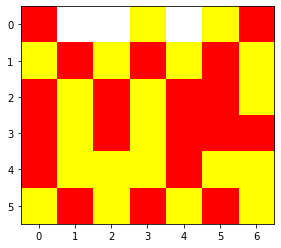


Number of nodes searched: 11


(inf, 2)

2.22 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [49]:
# red is about to win (play in column 2)

board = np.array([[1,0,0,-1,0,-1,1],
                  [-1,1,-1,1,-1,1,-1],
                  [1,-1,1,-1,1,1,-1],
                  [1,-1,1,-1,1,1,1],
                  [1,-1,-1,-1,1,-1,-1],
                  [-1,1,-1,1,-1,1,-1]])

print("Board:")
print(board)
show_board(board)

print()
%timeit -n 1 -r 1 display(alpha_beta_search(board))

Board:
[[ 0  0  0  0  0  0  1]
 [ 1 -1 -1 -1  1 -1  1]
 [-1  1 -1  1 -1  1 -1]
 [ 1 -1  1 -1  1  1 -1]
 [ 1 -1  1 -1  1  1  1]
 [ 1 -1 -1 -1  1 -1 -1]]


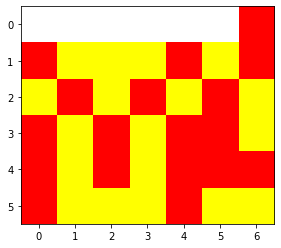


Number of nodes searched: 418


(-inf, None)

49.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [50]:
# red is about to win (play in column 5)

"""TODO: Why does the utility suggest that yellow already has won?"""

board = np.array([[0,0,0,0,0,0,1],
                  [1,-1,-1,-1,1,-1,1],
                  [-1,1,-1,1,-1,1,-1],
                  [1,-1,1,-1,1,1,-1],
                  [1,-1,1,-1,1,1,1],
                  [1,-1,-1,-1,1,-1,-1]])

print("Board:")
print(board)
show_board(board)

print()
%timeit -n 1 -r 1 display(alpha_beta_search(board))

Board:
[[ 0  0  0  0  1 -1  1]
 [ 1 -1 -1 -1  1 -1  1]
 [-1  1 -1  1 -1  1 -1]
 [ 1 -1  1 -1  1  1 -1]
 [ 1 -1  1 -1  1  1  1]
 [ 1 -1 -1 -1  1 -1 -1]]


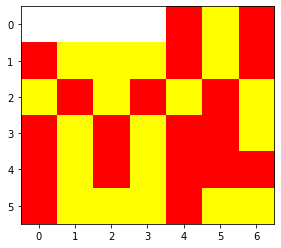


Number of nodes searched: 61


(0, 0)

10.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [51]:
# red can draw if it chooses 0.

board = np.array([[0,0,0,0,1,-1,1],
                  [1,-1,-1,-1,1,-1,1],
                  [-1,1,-1,1,-1,1,-1],
                  [1,-1,1,-1,1,1,-1],
                  [1,-1,1,-1,1,1,1],
                  [1,-1,-1,-1,1,-1,-1]])

print("Board:")
print(board)
show_board(board)

print()
%timeit -n 1 -r 1 display(alpha_beta_search(board))

Board:
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -1  0]
 [ 0  1 -1  1  0  1  0]
 [ 1 -1  1 -1  0 -1  1]
 [-1 -1  1 -1  1 -1  1]
 [ 1  1 -1 -1  1 -1 -1]]


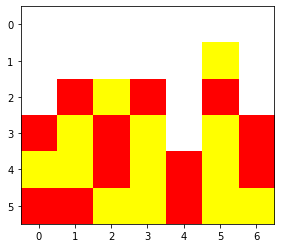


Number of nodes searched: 293714


(inf, 3)

19.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [52]:
# red can win if it chooses 3. Even though red is preventing yellow from winning this turn,
# a subtle shift also occurs where red is guaranteed to win since both players play optimally.

board = np.array([[0,0,0,0,0,0,0],
                  [0,0,0,0,0,-1,0],
                  [0,1,-1,1,0,1,0],
                  [1,-1,1,-1,0,-1,1],
                  [-1,-1,1,-1,1,-1,1],
                  [1,1,-1,-1,1,-1,-1]])

print("Board:")
print(board)
show_board(board)

print()
%timeit -n 1 -r 1 display(alpha_beta_search(board))

Board:
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0]
 [ 1 -1  0  0  0 -1  1]
 [-1 -1  1  0  1 -1  1]
 [ 1  1 -1 -1  1 -1 -1]
 [ 1 -1  1 -1 -1  1 -1]]


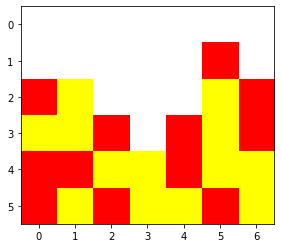


Number of nodes searched: 642479


(inf, 3)

42.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [53]:
# red can win if it chooses 3, because that sets up a trap where red has two winning opportunies at the same time.

board = np.array([[0,0,0,0,0,0,0],
                  [0,0,0,0,0,1,0],
                  [1,-1,0,0,0,-1,1],
                  [-1,-1,1,0,1,-1,1],
                  [1,1,-1,-1,1,-1,-1],
                  [1,-1,1,-1,-1,1,-1]])

print("Board:")
print(board)
show_board(board)

print()
%timeit -n 1 -r 1 display(alpha_beta_search(board))

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

* For a 6x7 board that is nearly empty, alpha-beta search takes an substantial amount of time to make a move.
* With a 6x4 board that is also nearly empty, the search takes much less time to make a move.

### Move ordering

Describe and implement a simple move ordering strategy. How does this strategy influence the time it takes to 
make a move?

* My implementation for move ordering is above my alpha-beta search function. The agent prioritizes centralized moves over moves towards the edges of the board. This strategy significantly reduces the time it takes to make a move, because terminal states are reached faster when better moves are considered first that generally allow for more future winning opportunities.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [ ]:
# TODO: Each agent plays their first nine moves centrally (yet randomly: 2,3,4).
# TODO: Then, they play their next four moves non-centrally (yet randomly: 0,1,5,6).
# TODO: Finally, they play the remainder of the game based on searching.

# Your code/ answer goes here.

## Task 4: Heuristic Alpha-Beta Tree Search [3 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [ ]:
# Your code/ answer goes here.

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [ ]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Playtime

Let two heuristic search agents (different cutoff depth or different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.

## Challenge task [+ 1 bonus point]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlos Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above. 

In [ ]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move is? You can use Pure Monte Carlo Search or any algorithms 
that you have implemented above.

In [ ]:
# Your code/ answer goes here.